In [1]:
using LinearAlgebra, RowEchelon, LaTeXStrings, Plots, SymPy
using Random, Distributions

#] dev --local "LAcode.jl"
#using LAcode
#title( "The Singular Value Decomposition", sz=30, color="darkred")

<div style="float:center;width:100%;text-align: center;"><strong style="height:60px;color:darkred;font-size:40px;">Some SVD Applications</strong><br></div>

> Let us rewrite the SVD equation:
> $$\begin{align}A &= U_r \Sigma_r V_r^t = \color{red}{\sigma_1} u_1 v_1^t + \color{red}{\sigma_2} u_2 v_2^t + \dots \color{red}{\sigma_r} u_r v_r^t.
\end{align}$$

> This clearly show the action of $A$ on a vector $x$:<br>
$\quad\quad\ \color{red}{\sigma_i}\ u_i v_i^t\; x = (\color{red}{\sigma_i}\ v_i \cdot x)\ u_i \quad$ computes the length of the orthogonal projection of $x$ onto $v_i$<br>
$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\;$ scales it by $\sigma_i$<br>
$\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\;$ and assigns it to the corresponding vector $u_i$.

# 1. The Eckart-Young Theorem

**Idea**

$\quad\quad A = \sigma_1\ u_1 v_1^t + \sigma_2\ u_2 v_2^t + \dots \sigma_r\ u_r v_r^t,\;\;$ where
$\quad \sigma_1 \ge \sigma_2 \dots \ge \sigma_r >0.$

$\quad$ Terms decrease in importance with increasing index. How about **truncating the series?**<br>
$\qquad$ $A_k = \sigma_1\ u_1 v_1^t + \sigma_2\ u_2 v_2^t + \dots \sigma_r\ u_k v_k^t$, where $1 \le k \le r$<br>$\qquad$ is known as a **low rank approximation** of $A$

**Remarks:**
* The basis vectors are ordered by their contribution to $A = U_r \Sigma_r V^t_r$:<br>
$\quad$ The **first column vector** in $V_r$ is associated with the **largest** $\mathbf{\sigma_1}$ value
* In practice, many matrices have singular values that decrease very sharply: $\quad \frac{\sigma_1}{\sigma_r} \gg 1$

<div style="float:left;width:100%;background-color:#F2F5A9;">

**Theorem:**<br>
$\quad$ Let $A = U \Sigma V^t$ be a singular value decomposition of $A$, whith $rank A = r$.

$\quad$ Let $A_k = \sum_{i=1}^k{\sigma_i \ u_i v^t_i}\ $ be the $rank\ k$ approximation obtained from the SVD.

$\quad$ For any matrix $B$ of $rank\ k$, we have $\lVert A - B \rVert \ge \lVert A - A_k \rVert.$
</div>

**Remarks:**
* The theorem holds for any norm that depends only on the singular values.<br>
$\quad$ For now, we will use the Frobenius norm $\lVert A \rVert = \lVert vec(A) \rVert,$<br>
$\quad$ i.e., $\lVert A \rVert = \left( \sum_{i=1}^M \sum_{j=1}^N { a^2_{i j}} \right)^\frac{1}{2}$

* The theorem says that $A_k = \underset{B}{\operatorname{argmin}}\ \lVert A - B \rVert,$<br>$\quad$ i.e., $A_k$ is the closest approximation to $A$
in this norm.

# 2. Low Rank Approximation of an Image

$A_k$ approximates $A$. In this example $A$ is an **image made up of pixel color values** on a rectangular grid.

In [67]:
using Images, TestImages, MosaicViews
img = float.(testimage("mandrill"))
channels = channelview(img)

function rank_approx(F::SVD, k)
    U, S, V = F
    M = U[:, 1:k] * Diagonal(S[1:k]) * V[:, 1:k]'
    clamp01!(M)
end
function kscale( v, k)
    v*k
end
function tail_approx(F::SVD, start,k)
    U, S, V = F
    M = U[:, start:end] * Diagonal(kscale.(S[start:end], k)) * V[:, start:end]'
    clamp01!(M)
end

svdfactors = svd.(eachslice(channels; dims=1));

##### **Plots**

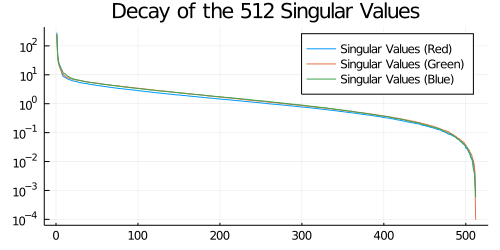

In [3]:
plot(  svdfactors[1].S, yscale=:log10, label="Singular Values (Red)")
plot!( svdfactors[2].S, yscale=:log10, label="Singular Values (Green)")
plot!( svdfactors[3].S, yscale=:log10, label="Singular Values (Blue)", size=(500,250))
plot!(title="Decay of the 512 Singular Values")

**Remark:** For many applications encountered in practice, this distribution of the singular values is typical:<br>
$\quad$ a number of dominant values and a rapid decay in the values

Original Image, 2, 10, 50 terms


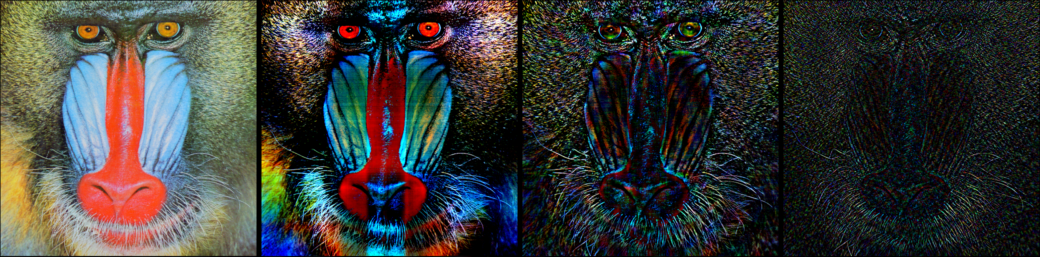

In [69]:
# imgs = map((2, 10, 50)) do k
#    colorview(RGB, rank_approx.(svdfactors, k)...)
#end
imgs = map((2, 10, 50)) do k
    colorview(RGB, tail_approx.(svdfactors, k, 3.1)...)
end

    
println("Original Image, 2, 10, 50 terms")
mosaicview(img, imgs...; nrow=1, npad=10)

In [5]:
# Current Jupyterlab not compatible with WebIO
#using Interact
#@manipulate for i in 1:length(svdfactors[1].S)
#    mosaicview(img, colorview(RGB, rank_approx.(svdfactors, i)...), nrow=1,npad=10)
#end

## 3. Principal Component Analysis

The column space vectors in $U$ form a basis for $\mathscr{C}(A)$ **ranked by their importance:**<br>
$\quad$ $u_1$ corresponds to $\sigma_1$, etc.

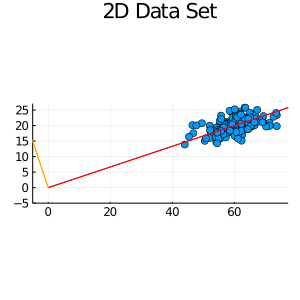

In [6]:
rng     = MersenneTwister(1511) # fixed seed: generate the same data set each time 
Npoints = 150
A       = rand(MvNormal( [60.; 20],[ 161.0 36.0; 36.0 26.0]/5), Npoints)'

EV      = eigen(A'A)
V       = EV.vectors         # Singular Vectors of A (most significant is last)
σ       = sqrt.(EV.values)   # Singular Values  of A (largest is last)

scatter(A[:,1], A[:,2], legend=:none, aspect_ratio=:equal,
        xlims=(-5, 1.05*maximum(A[:,1])),
        ylims=(-5, 1.05*maximum(A[:,2])),
        title="2D Data Set", size=(300,300) )
plot!([0; -σ[2]*V[1,2]], [0; -σ[2]*V[2,2]], arrow = true, color="red")
plot!([0; -σ[1]*V[1,1]], [0; -σ[1]*V[2,1]], arrow = true, color="orange")

We see a 2D data set with $x_1$ and $x_2$ arranged in columns of a matrix $A$ of size $N_{points} \times 2$

A reduced SVD $\;\;A\ =\ U_r\ \Sigma_r\ V^t_r$ contains an othogonal basis $\left\{ v_1, v_2 \right\}$ for $\mathscr{R}(A)$,<br>$\quad$ i.e., a set of axes for the plot above.

We see the first singular vector $v_1$. The second singular vector is orthogonal to the first<br>$\quad$ and thus not visible.

It may be better to **center the coordinate system** on the cluster:<br>
$\quad$ **subtract out the mean of the data.**

In [7]:
x_mean = mean(A[:,1])
y_mean = mean(A[:,2])

Ac = [(A[:,1] .- x_mean) (A[:,2] .- y_mean)];

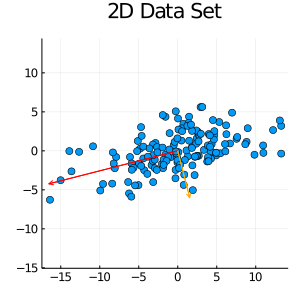

In [8]:
EV      = eigen(Ac'Ac)
V       = EV.vectors         # Singular Vectors of A (most significant is last)
σ       = sqrt.(EV.values)   # Singular Values  of A (largest is last)
scale   = 3* 1.0/sqrt(Npoints - 1.)
scatter(Ac[:,1], Ac[:,2], legend=:none, aspect_ratio=:equal,
        title="2D Data Set", size=(300,300) )
plot!([0; scale*σ[2]*V[1,2]], [0; scale*σ[2]*V[2,2]], arrow = true, color="red")
plot!([0; scale*σ[1]*V[1,1]], [0; scale*σ[1]*V[2,1]], arrow = true, color="orange")

The first singular vector appears to be oriented along a principal direction of the cluster!<br>
$\quad$ In this plot, the singular vectors were scaled to the extent of the data set.

PCA attempts to find principal directions that maximize the **variance of the data**<br>
$\quad$ projected orthogonally onto that axis.

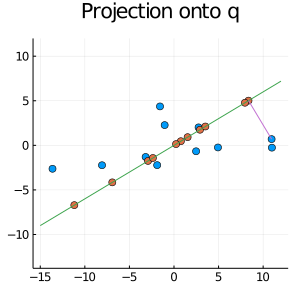

In [57]:
function points_on_line( A, slope )
    q = [1;slope] / sqrt(1+slope^2)
    d = A * q              # distance from the origin
    [(d .* q[1]) (d .* q[2]) ]
end
slope = 3/5
start = 6
Ap    = Ac[start:3:30+start,:]  # plot just a subset of the points
p     = points_on_line( Ap, slope)
scatter(Ap[:,1], Ap[:,2], legend=:none, aspect_ratio=:equal,
        title="Projection onto q", size=(300,300) )
scatter!(p[:,1], p[:,2])
plot!([-15; 12],[-15*slope; 12*slope])
k=1
plot!( [Ap[k,1];p[k,1]], [Ap[k,2];p[k,2]])

PCA: find a line that **maximizes** the variance of the orthogonal projections<br>$\qquad$ of the data onto the line, i.e., the **square of the euclidean distance** of the projected points from the origin

<div style="float:left;width:100%;background-color:#F2F5A9;">

**Theorem:** Given a matrix $A \in \mathbb{R}^{M \times N}$ with reduced SVD $A = U_r \Sigma_r V^t_r$. Then

$\quad$ $\sigma^2_1 = \quad \underset{\lVert q \rVert = 1}{\operatorname{max}}\;\; q^t A^t\ A\ q$, 
$\quad$ $\ v_1 = \; \underset{\lVert q \rVert = 1}{\operatorname{argmax}}\ q^t A^t\ A\ q$,<br>
<!-- -->
$\quad$ $\sigma^2_2 = \underset{\lVert q \rVert = 1, q \perp v_1}{\operatorname{max}}\ q^t A^t\ A\ q$, 
$\quad$ $v_2 = \underset{\lVert q \rVert = 1, q \perp v_1}{\operatorname{argmax}}\ q^t A^t\ A\ q$,<br>
$\quad \dots$ 
</div>

* The **principal directions** $v_i$ are the singular vectors of $A$
* The singular values are the **standard deviations** of the data<br>
$\quad$ along the principal
directions (multiplied by $\sqrt{M-1}$).

# 4. Some Web Resources

|URL|Description|
|:----|:----|
| https://tungmphung.com/principal-component-analysis-fully-explained/ | PCA and total least squares |
| https://www.youtube.com/watch?v=fkf4IBRSeEc | Brunton: Principal Component Analysis |
| https://www.cs.princeton.edu/courses/archive/spring12/cos598C/svdchapter.pdf | Sanjeev Arora: The SVD |
| https://intoli.com/blog/pca-and-svd/ | The relationship of the SVD to PCA |
|  | |
| https://www.youtube.com/watch?v=_wOt50VnJw4     | Brunton: Geometric Interpretation of the SVD |
| https://www.youtube.com/watch?v=QQ8vxj-9OfQ     | Brunton: Image Compression using the SVD |
| https://towardsdatascience.com/svd-8c2f72e264f  | Understanding the SVD |
| https://github.com/RoyiAvital/Projects/tree/master/SingularValueDecomposition | Another Presentation of the SVD |